# CSM148 Project 3: Stroke Prediction

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [2]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [29]:
def print_metrics(y_test, preds):
    print("%-12s %f" % ("Accuracy:", accuracy_score(y_test, preds)))
    print("%-12s %f" % ("Precision:", precision_score(y_test, preds)))
    print("%-12s %f" % ("Recall:", recall_score(y_test, preds)))
    print("%-12s %f" % ("F1 score:", f1_score(y_test, preds)))

## Load data & basic statistics

In [165]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [680]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [166]:
data.drop("id", axis=1, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


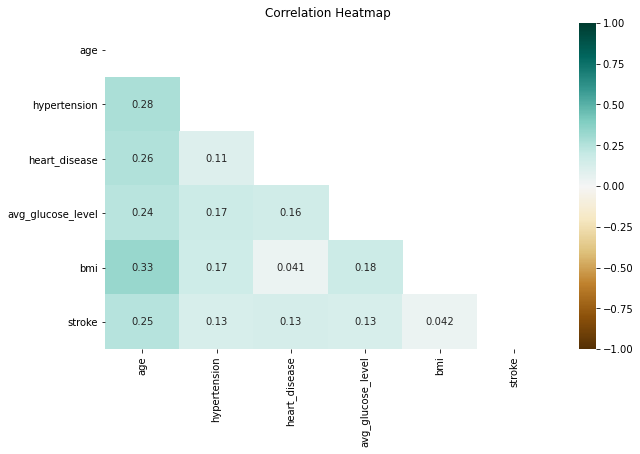

In [682]:
corr = data.corr()
plt.figure(figsize=(10,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title("Correlation Heatmap")
plt.show()

Temporarily encode categoricals to run OLS and produce another correlation matrix considering all features.

In [180]:
data_copy = data.drop(['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis=1, inplace=False)
cat_features = ['ever_married', 'Residence_type', 'gender', 'work_type', 'smoking_status']
for cat in cat_features:
    enc = pd.DataFrame(OrdinalEncoder().fit_transform(data[[cat]]), columns=['{}_enc'.format(cat)])
    data_copy = data_copy.join(enc, how='right')

In [181]:
# move stroke feature to end, easier to visualize
data_copy.insert(len(data_copy.columns), 'stroke_new', data_copy['stroke'], allow_duplicates=True)
data_copy.drop('stroke', axis=1, inplace=True)
data_copy

,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married_enc,Residence_type_enc,gender_enc,work_type_enc,smoking_status_enc,stroke_new
0,67.0,0,1,228.69,36.6,1.0,1.0,1.0,2.0,1.0,1
1,61.0,0,0,202.21,NaN,1.0,0.0,0.0,3.0,2.0,1
2,80.0,0,1,105.92,32.5,1.0,0.0,1.0,2.0,2.0,1
3,49.0,0,0,171.23,34.4,1.0,1.0,0.0,2.0,3.0,1
4,79.0,1,0,174.12,24.0,1.0,0.0,0.0,3.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,NaN,1.0,1.0,0.0,2.0,2.0,0
5106,81.0,0,0,125.20,40.0,1.0,1.0,0.0,3.0,2.0,0
5107,35.0,0,0,82.99,30.6,1.0,0.0,0.0,3.0,2.0,0
5108,51.0,0,0,166.29,25.6,1.0,0.0,1.0,2.0,1.0,0


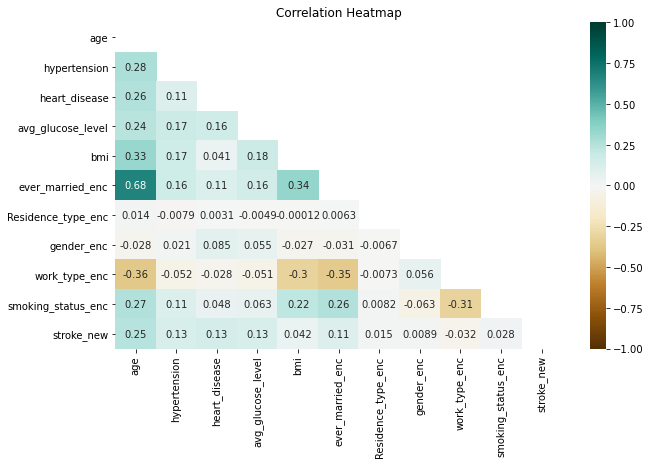

In [182]:
corr = data_copy.corr()
plt.figure(figsize=(10,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title("Correlation Heatmap")
plt.show()

In [6]:
# save the label column as a separate array and then drop it from the dataframe
y = data["stroke"]
data.drop("stroke", axis=1, inplace=True, errors='ignore')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


## Pipeline

Try three imputation strategies for nulls in bmi: (1) drop bmi feature, (2) replace with median, (3) replace with mean. \
Augment with age^2, age\*heart_disease, and hypertension\*heart_disease

In [7]:
data_drop = data.drop("bmi", axis=1) # imputation strategy: drop bmi
data_drop

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,never smoked
...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,never smoked
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,never smoked
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,never smoked
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,formerly smoked


In [8]:
num_data = data.select_dtypes(exclude=['object'])
cat_data = data.select_dtypes(include=['object'])
num_cols = list(num_data.columns)
cat_cols = list(cat_data.columns)

num_cols_drop = [col for col in num_cols if col != "bmi"] # numerical columns for dropped bmi pipeline
cat_cols_le = ["ever_married", "Residence_type"] # binary categorial features to label encode
cat_cols_ohe = [col for col in cat_cols if col not in cat_cols_le] # binary categorial features to one-hot encode

print("All numerical features: ", num_cols)
print("Numerical features without bmi: ", num_cols_drop)
print("Categorical features to one-hot encode: ", cat_cols_ohe)
print("Categorical features to label encode: ", cat_cols_le)

All numerical features:  ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
Numerical features without bmi:  ['age', 'hypertension', 'heart_disease', 'avg_glucose_level']
Categorical features to one-hot encode:  ['gender', 'work_type', 'smoking_status']
Categorical features to label encode:  ['ever_married', 'Residence_type']


In [9]:
age_idx, hyper_idx, disease_idx = 0, 1, 2

class AugmentFeatures(BaseEstimator, TransformerMixin):
    '''
    Augments with: age**2, age*heart_disease, hypertension*heart_disease
    '''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if isinstance(X, pd.DataFrame): # data_drop case
            age_sq = X["age"] * X["age"]
            age_disease = X["age"] * X["heart_disease"]
            hyper_disease = X["hypertension"] * X["heart_disease"]
        else: # median and knn cases
            age_sq = X[:, age_idx] * X[:, age_idx]
            age_disease = X[:, age_idx] * X[:, disease_idx]
            hyper_disease = X[:, hyper_idx] * X[:, disease_idx]
        return np.c_[X, age_sq, age_disease, hyper_disease]

class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    # code from: https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

# pipeline with bmi dropped
num_pipeline = Pipeline([
        ('attribs_adder', AugmentFeatures()),
        ('std_scaler', StandardScaler()),
    ])
full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols_drop),
        ('cat_ohe', OneHotEncoder(), cat_cols_ohe),
        ('cat_le', MultiColumnLabelEncoder(), cat_cols_le),
    ])

# pipeline replacing nulls with median
num_pipeline_med = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', AugmentFeatures()),
        ('std_scaler', StandardScaler()),
    ])
full_pipeline_med = ColumnTransformer([
        ('num', num_pipeline_med, num_cols),
        ('cat_ohe', OneHotEncoder(), cat_cols_ohe),
        ('cat_le', MultiColumnLabelEncoder(), cat_cols_le),
    ])

# pipeline replacing nulls with mean
num_pipeline_knn = Pipeline([
        ('imputer', KNNImputer()),
        ('attribs_adder', AugmentFeatures()),
        ('std_scaler', StandardScaler()),
    ])
full_pipeline_knn = ColumnTransformer([
        ('num', num_pipeline_knn, num_cols),
        ('cat_ohe', OneHotEncoder(), cat_cols_ohe),
        ('cat_le', MultiColumnLabelEncoder(), cat_cols_le),
    ])

# transform data
data_prep_drop = full_pipeline.fit_transform(data_drop)
data_prep_med = full_pipeline_med.fit_transform(data)
data_prep_knn = full_pipeline_knn.fit_transform(data)

In [725]:
# age, hypertension, heart_disease, avg_glucose_level, age_sq, age_disease, hyper_disease, work_type[0:4], smoking_status[0:3], gender, ever_married, Residence_type
data_prep_drop[:3]

array([[ 1.05143428, -0.32860186,  4.18503199,  2.70637544,  1.08047285,
         4.04657872, -0.11262022,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         1.        ],
       [ 0.78607007, -0.32860186, -0.2389468 ,  2.12155854,  0.68705729,
        -0.23537818, -0.11262022,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ],
       [ 1.62639008, -0.32860186,  4.18503199, -0.0050283 ,  2.05940142,
         4.87740618, -0.11262022,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ]])

In [726]:
# age, hypertension, heart_disease, avg_glucose_level, bmi, age_sq, age_disease, hyper_disease, work_type[0:4], smoking_status[0:3], gender, ever_married, Residence_type
data_prep_med[:3]

[[ 1.05143428 -0.32860186  4.18503199  2.70637544  1.00508597  1.08047285
   4.04657872 -0.11262022  0.          1.          0.          0.
   0.          1.          0.          0.          0.          1.
   0.          0.          1.          1.        ]
 [ 0.78607007 -0.32860186 -0.2389468   2.12155854 -0.09898092  0.68705729
  -0.23537818 -0.11262022  1.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   1.          0.          1.          0.        ]
 [ 1.62639008 -0.32860186  4.18503199 -0.0050283   0.47253605  2.05940142
   4.87740618 -0.11262022  0.          1.          0.          0.
   0.          1.          0.          0.          0.          0.
   1.          0.          1.          0.        ]]


In [727]:
# age, hypertension, heart_disease, avg_glucose_level, bmi, work_type[0:4], smoking_status[0:3], gender, ever_married, Residence_type
data_prep_knn[:3]

[[ 1.05143428 -0.32860186  4.18503199  2.70637544  0.98563647  1.08047285
   4.04657872 -0.11262022  0.          1.          0.          0.
   0.          1.          0.          0.          0.          1.
   0.          0.          1.          1.        ]
 [ 0.78607007 -0.32860186 -0.2389468   2.12155854  0.31354701  0.68705729
  -0.23537818 -0.11262022  1.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   1.          0.          1.          0.        ]
 [ 1.62639008 -0.32860186  4.18503199 -0.0050283   0.45775011  2.05940142
   4.87740618 -0.11262022  0.          1.          0.          0.
   0.          1.          0.          0.          0.          0.
   1.          0.          1.          0.        ]]


In [10]:
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(data_prep_drop, y, test_size=0.2, random_state=0)
print(X_train_drop.shape, y_train_drop.shape)
print(X_test_drop.shape, y_test_drop.shape)

(4088, 21) (4088,)
(1022, 21) (1022,)


In [11]:
X_train_med, X_test_med, y_train_med, y_test_med = train_test_split(data_prep_med, y, test_size=0.2, random_state=0)
print(X_train_med.shape, y_train_med.shape)
print(X_test_med.shape, y_test_med.shape)

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(data_prep_knn, y, test_size=0.2, random_state=0)
print(X_train_knn.shape, y_train_knn.shape)
print(X_test_knn.shape, y_test_knn.shape)

(4088, 22) (4088,)
(1022, 22) (1022,)
(4088, 22) (4088,)
(1022, 22) (1022,)


### Ordinary least squares

In [184]:
stats_model = sm.OLS(y, data_prep_drop)
stats = stats_model.fit()
print(stats.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     28.74
Date:                Mon, 31 May 2021   Prob (F-statistic):           2.51e-93
Time:                        21:41:41   Log-Likelihood:                 844.05
No. Observations:                5110   AIC:                            -1650.
Df Residuals:                    5091   BIC:                            -1526.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0694      0.022     -3.203      0.0

### Balance the training set: upsample minority class

In [12]:
# code from: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

def resample_train(X_train, y_train, sampling):
    # concatenate our training data back together
    X = np.c_[X_train, y_train]
    # separate minority and majority classes
    no_stroke = X[X[:,-1]==0]
    stroke = X[X[:,-1]==1]
    
    # upsample minority
    stroke_upsampled = resample(stroke, replace=True, n_samples=len(no_stroke), random_state=0)
    # combine majority and upsampled minority
    upsampled = np.vstack((no_stroke, stroke_upsampled))
    
    # downsample majority
    no_stroke_downsampled = resample(no_stroke, replace=False, n_samples=len(stroke), random_state=0)
    # combine downsampled majority and minority
    downsampled = np.vstack((no_stroke_downsampled, stroke))
    
    if sampling=='up':
        X_train_new = upsampled[:,:-1] # all but last column
        y_train_new = upsampled[:,-1] # only last column
    else:
        X_train_new = downsampled[:,:-1] # all but last column
        y_train_new = downsampled[:,-1] # only last column
    
    return X_train_new, y_train_new

#### Dropped dataset

In [13]:
X_train_drop_up, y_train_drop_up = resample_train(X_train_drop, y_train_drop, sampling='up')
print (X_train_drop_up.shape, y_train_drop_up.shape)

(7786, 21) (7786,)


#### Median dataset

In [14]:
X_train_med_up, y_train_med_up = resample_train(X_train_med, y_train_med, sampling='up')
print (X_train_med_up.shape, y_train_med_up.shape)

(7786, 22) (7786,)


#### KNN dataset

In [15]:
X_train_knn_up, y_train_knn_up = resample_train(X_train_knn, y_train_knn, sampling='up')
print (X_train_knn_up.shape, y_train_knn_up.shape)

(7786, 22) (7786,)


### Balance the training set: downsample majority class
Probably not as good, just try it on dropped dataset.

In [16]:
X_train_down, y_train_down = resample_train(X_train_drop, y_train_drop, sampling='down')
print (X_train_down.shape, y_train_down.shape)

(390, 21) (390,)


## Logistic regression on balanced data

In [31]:
def lr_balanced(X_train, X_test, y_train, y_test, draw_cm=False, plot_roc=False):
    lr = LogisticRegression(random_state=0, max_iter=200)
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    print_metrics(y_test, preds)
    if draw_cm:
        draw_confusion_matrix(y_test, preds, ["No stroke", "Stroke"])
    if plot_roc:
        plot_roc_curve(lr, X_test, y_test)
        plt.show()

### Dropped dataset

Accuracy:    0.749511
Precision:   0.141844
Recall:      0.740741
F1 score:    0.238095


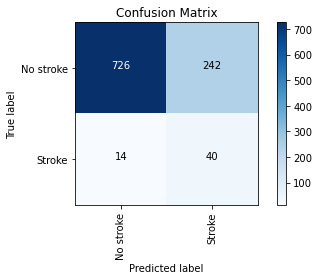

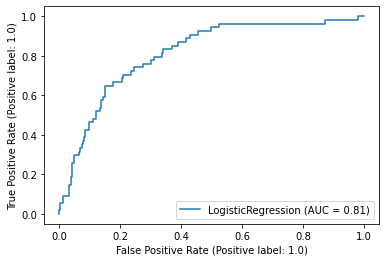

In [34]:
lr_balanced(X_train_drop_up, X_test_drop, y_train_drop_up, y_test_drop, draw_cm=True, plot_roc=True)

### Median dataset

In [697]:
lr_balanced(X_train_med_up, X_test_med, y_train_med_up, y_test_med)

Accuracy:    0.746575
Precision:   0.140351
Recall:      0.740741
F1 score:    0.235988


### KNN dataset

In [698]:
lr_balanced(X_train_knn_up, X_test_knn, y_train_knn_up, y_test_knn)

Accuracy:    0.747554
Precision:   0.140845
Recall:      0.740741
F1 score:    0.236686


### Downsampled dataset

In [699]:
lr_balanced(X_train_down, X_test_drop, y_train_down, y_test)

Accuracy:    0.734834
Precision:   0.137124
Recall:      0.759259
F1 score:    0.232295


Basic logistic regression shows that a model fit to downsampled training data performs worse than one fit to oversampled training data, and imputation by dropping bmi performs better than replacing with either median or a knn average.

## Cross validate logistic regression on balanced data

In [35]:
# code from: https://github.com/lumiata/tech_blog/blob/master/Cross_Validation_Imbalanced_Datasets/cross-validation.ipynb

def cv_balanced(X_train, y_train, set_label):
    kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    cv_f1_score_lst = []
    cv_accuracy_lst = []
    cv_recall_lst = []
    cv_precision_lst = []
    
    for train_idx_ls, test_idx_ls in kf.split(X_train, y_train):
        X_train_kf, X_test_kf = X_train[train_idx_ls], X_train[test_idx_ls]
        y_train_kf, y_test_kf = y_train.iloc[train_idx_ls], y_train.iloc[test_idx_ls]

        if set_label!='downsampled':
            sampler = SMOTE(random_state=0)
        else:
            sampler = RandomUnderSampler(random_state=0)

        X_train_res, y_train_res = sampler.fit_resample(X_train_kf, y_train_kf)
        # print(X_train_res.shape, y_train_res.shape)

        lr_kf = LogisticRegression(random_state=0, max_iter=200)
        lr_kf.fit(X_train_res, y_train_res)

        test_preds = lr_kf.predict(X_test_kf)

        cv_recall_lst.append(recall_score(y_test_kf, test_preds))
        cv_accuracy_lst.append(accuracy_score(y_test_kf, test_preds))
        cv_precision_lst.append(precision_score(y_test_kf, test_preds))
        cv_f1_score_lst.append(f1_score(y_test_kf, test_preds))
    
    print ('Dataset:', set_label)
    print ('Cross validated accuracy: {}'.format(np.mean(cv_accuracy_lst)))
    print ('Cross validated precision: {}'.format(np.mean(cv_precision_lst)))
    print ('Cross validated recall: {}'.format(np.mean(cv_recall_lst)))
    print ('Cross validated F1: {}'.format(np.mean(cv_f1_score_lst)))

In [19]:
balanced_sets = [[X_train_drop, y_train_drop], [X_train_med, y_train_med], [X_train_knn, y_train_knn], [X_train_drop, y_train_drop]]
set_label = ["dropped", "median", "knn", "downsampled"]
count = 0

for X_train, y_train in balanced_sets:
    cv_balanced(X_train, y_train, set_label=set_label[count])
    print()
    count += 1

Dataset: dropped
Cross validated accuracy: 0.7304257155184811
Cross validated precision: 0.13024707648692208
Cross validated recall: 0.8149999999999998
Cross validated F1: 0.2244479053862772

Dataset: median
Cross validated accuracy: 0.7304251162567716
Cross validated precision: 0.1295912884132166
Cross validated recall: 0.8102631578947367
Cross validated F1: 0.22335847016103338

Dataset: knn
Cross validated accuracy: 0.729936717963469
Cross validated precision: 0.12949401727935456
Cross validated recall: 0.8102631578947367
Cross validated F1: 0.22318588451215288

Dataset: downsampled
Cross validated accuracy: 0.737028980296275
Cross validated precision: 0.129960000795603
Cross validated recall: 0.7894736842105263
Cross validated F1: 0.22307714339499318



Cross validation of logistic regression models on upsampled and downsampled data confirms that upsampling with the dropped bmi feature performs best, though all still have low F1 scores.

Dropped bmi and upsampled data will be used going forward.

In [36]:
X_train, X_test, y_train, y_test = X_train_drop, X_test_drop, y_train_drop, y_test_drop
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4088, 21) (4088,)
(1022, 21) (1022,)


## Principal component analysis

In [37]:
pca = PCA(n_components=0.95) # choose the minimum number of principal components such that 95% of variance is retained
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)
print(X_test_pca.shape)

(4088, 11)
(1022, 11)


In [38]:
cv_balanced(X_train_pca, y_train_drop, set_label='PCA')

Dataset: PCA
Cross validated accuracy: 0.7526852917206002
Cross validated precision: 0.13614282932443106
Cross validated recall: 0.7789473684210526
Cross validated F1: 0.2316382151979317


Logistic regression performs better after dimensionality reduction by PCA, indicating the model is less overfit and generalizes better to test data after being trained on PCA data.

In [39]:
# also perform PCA on dropped upsampled dataset
pca_up = PCA(n_components=0.95)
pca_up.fit(X_train_drop_up)
X_train_pca_up = pca_up.transform(X_train_drop_up)
X_test_pca_up = pca_up.transform(X_test_drop)

PCA data should be used going forward.

In [40]:
# use this if including upsampling within cross-validation
X_train, X_test, y_train, y_test = X_train_pca, X_test_pca, y_train_drop, y_test_drop
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4088, 11) (4088,)
(1022, 11) (1022,)


In [41]:
# use this if running basic model without cross-validation
X_train_up, X_test_up, y_train_up, y_test = X_train_pca_up, X_test_pca_up, y_train_drop_up, y_test_drop
print(X_train_up.shape, y_train_up.shape)
print(X_test_up.shape, y_test.shape)

(7786, 10) (7786,)
(1022, 10) (1022,)


## Ensemble methods

### Decision tree

In [42]:
# basic decision tree
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train_up, y_train_up)
preds_dt = dt.predict(X_test_up)
print_metrics(y_test, preds_dt)

Accuracy:    0.915851
Precision:   0.119048
Recall:      0.092593
F1 score:    0.104167


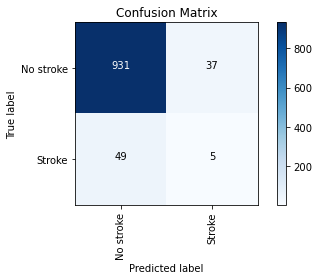

In [71]:
draw_confusion_matrix(y_test, preds_dt, ["No stroke", "Stroke"])

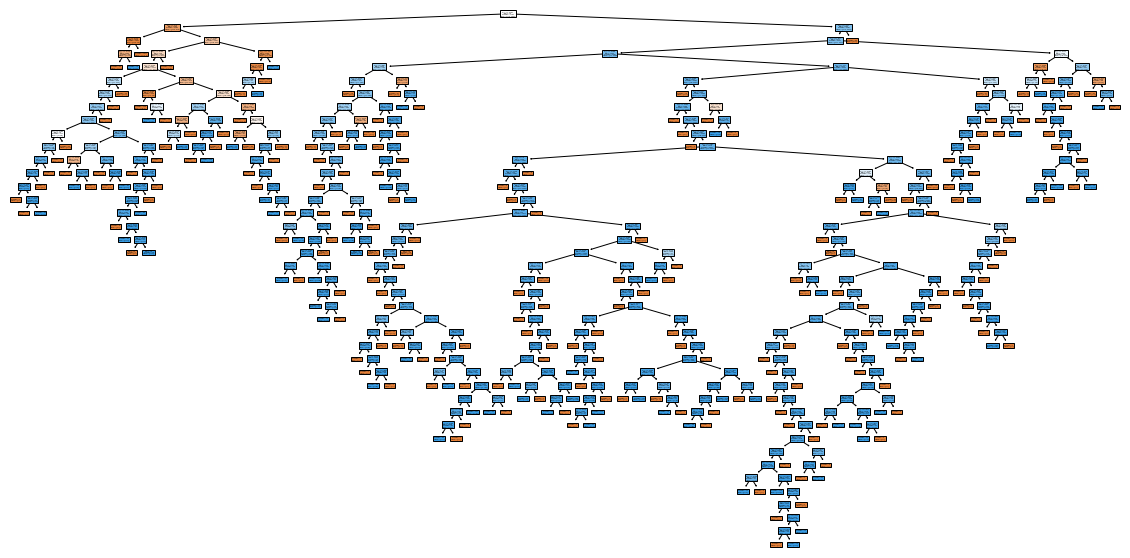

In [708]:
plt.figure(figsize=(20,10))
tree.plot_tree(dt, filled=True)
plt.show()

### Tuning tree parameters
Code from: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

In [52]:
max_leaf_nodes_arr = np.linspace(2, 30, 29, endpoint=True).astype(int)
max_depth_arr = np.linspace(1, 10, 10, endpoint=True).astype(int)

dt_params = dict(max_leaf_nodes=max_leaf_nodes_arr, max_depth=max_depth_arr)
dt_params = {'decisiontreeclassifier__' + key: dt_params[key] for key in dt_params}

In [187]:
# use a pipeline with GridSearchCV to upsample inside cross-validating decision trees to find best parameters
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
up_dt_pipeline = make_pipeline(SMOTE(random_state=0), DecisionTreeClassifier(random_state=0))
dt_GS = GridSearchCV(up_dt_pipeline, param_grid=dt_params, cv=kf, scoring='f1', return_train_score=True)
dt_GS.fit(X_train, y_train)

best_max_leaf_nodes = dt_GS.best_estimator_.get_params()['decisiontreeclassifier__max_leaf_nodes']
best_max_depth = dt_GS.best_estimator_.get_params()['decisiontreeclassifier__max_depth']
best_score = dt_GS.best_score_

print('Best max_leaf_nodes:', best_max_leaf_nodes)
print('Best max_depth:', best_max_depth)
print('Best score:', best_score)

Best max_leaf_nodes: 5
Best max_depth: 3
Best score: 0.22201353759725273


In [188]:
dt_GS_preds = dt_GS.predict(X_test)
print_metrics(y_test, dt_GS_preds)

Accuracy:    0.756360
Precision:   0.155477
Recall:      0.814815
F1 score:    0.261128


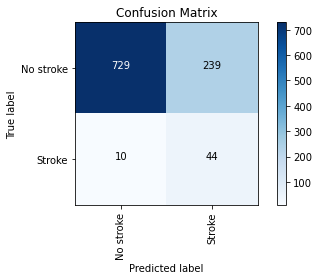

In [72]:
draw_confusion_matrix(y_test, dt_GS_preds, ["No stroke", "Stroke"])

In [54]:
best_params = {key.split('__')[1]: dt_GS.best_params_[key] for key in dt_GS.best_params_}
dt_best = DecisionTreeClassifier(**best_params, random_state=0)
dt_best

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=5, random_state=0)

### Bagging

In [55]:
n_estimators_arr = np.linspace(1, 30, 30, endpoint=True).astype(int)

bag_params = dict(n_estimators=n_estimators_arr)
bag_params = {'baggingclassifier__' + key: bag_params[key] for key in bag_params}

In [56]:
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
up_bag_pipeline = make_pipeline(SMOTE(random_state=0), BaggingClassifier(base_estimator=dt_best, random_state=0))
bag_GS = GridSearchCV(up_bag_pipeline, param_grid=bag_params, cv=kf, scoring='f1', return_train_score=True)
bag_GS.fit(X_train, y_train)

best_n_estimators = bag_GS.best_estimator_.get_params()['baggingclassifier__n_estimators']
best_score = bag_GS.best_score_

print('Best n_estimators:', best_n_estimators)
print('Best score:', best_score)

Best n_estimators: 11
Best score: 0.21999021738294627


In [57]:
bag_GS_preds = bag_GS.predict(X_test)
print_metrics(y_test, bag_GS_preds)

Accuracy:    0.748532
Precision:   0.151203
Recall:      0.814815
F1 score:    0.255072


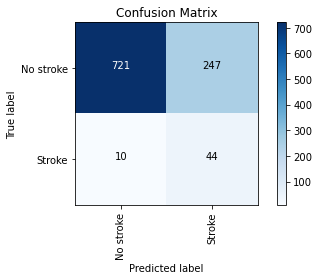

In [73]:
draw_confusion_matrix(y_test, bag_GS_preds, ["No stroke", "Stroke"])

### Random forest

In [58]:
n_estimators_arr = np.linspace(1, 30, 30, endpoint=True).astype(int)

rf_params = dict(n_estimators=n_estimators_arr)
rf_params = {'randomforestclassifier__' + key: rf_params[key] for key in rf_params}

In [59]:
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
up_rf_pipeline = make_pipeline(SMOTE(random_state=0), RandomForestClassifier(random_state=0))
rf_GS = GridSearchCV(up_rf_pipeline, param_grid=rf_params, cv=kf, scoring='f1', return_train_score=True)
rf_GS.fit(X_train, y_train)

best_n_estimators = rf_GS.best_estimator_.get_params()['randomforestclassifier__n_estimators']
best_score = rf_GS.best_score_

print('Best n_estimators:', best_n_estimators)
print('Best score:', best_score)

Best n_estimators: 1
Best score: 0.17675589427468347


In [60]:
rf_GS_preds = rf_GS.predict(X_test)
print_metrics(y_test, rf_GS_preds)

Accuracy:    0.857143
Precision:   0.110169
Recall:      0.240741
F1 score:    0.151163


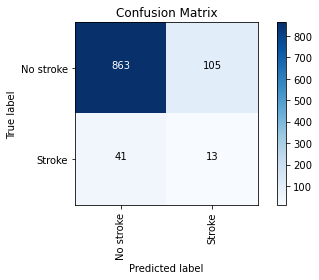

In [74]:
draw_confusion_matrix(y_test, rf_GS_preds, ["No stroke", "Stroke"])

### AdaBoost

In [61]:
from sklearn.ensemble import AdaBoostClassifier

n_estimators_arr = np.linspace(1, 30, 30, endpoint=True).astype(int)

ada_params = dict(n_estimators=n_estimators_arr)
ada_params = {'adaboostclassifier__' + key: ada_params[key] for key in ada_params}

In [62]:
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
up_ada_pipeline = make_pipeline(SMOTE(random_state=0), AdaBoostClassifier(base_estimator=dt_best, random_state=0))
ada_GS = GridSearchCV(up_ada_pipeline, param_grid=ada_params, cv=kf, scoring='f1', return_train_score=True)
ada_GS.fit(X_train, y_train)

best_n_estimators = ada_GS.best_estimator_.get_params()['adaboostclassifier__n_estimators']
best_score = ada_GS.best_score_

print('Best n_estimators:', best_n_estimators)
print('Best score:', best_score)

Best n_estimators: 1
Best score: 0.21566720284453136


In [63]:
ada_GS_preds = ada_GS.predict(X_test)
print_metrics(y_test, ada_GS_preds)

Accuracy:    0.756360
Precision:   0.155477
Recall:      0.814815
F1 score:    0.261128


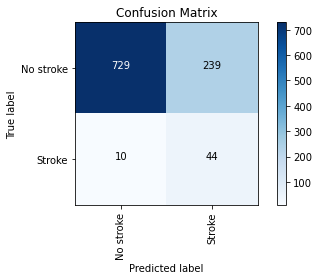

In [75]:
draw_confusion_matrix(y_test, ada_GS_preds, ["No stroke", "Stroke"])

## Neural network

In [46]:
#hidden_layer_sizes_arr = np.linspace(16, 36, 3, endpoint=True).astype(int)
#hidden_layer_sizes_arr = [(hidden_layer_sizes_arr[i], hidden_layer_sizes_arr[j]) for i in range(3) for j in range(3)]
activation_arr = ['identity', 'logistic', 'tanh', 'relu']

nn_params = dict(activation=activation_arr)
nn_params = {'mlpclassifier__' + key: nn_params[key] for key in nn_params}

In [47]:
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
up_nn_pipeline = make_pipeline(SMOTE(random_state=0), MLPClassifier(hidden_layer_sizes=(16,),max_iter=2000, random_state=0, verbose=True))
nn_GS = GridSearchCV(up_nn_pipeline, param_grid=nn_params, cv=kf, scoring='f1', return_train_score=True, n_jobs=-1)
nn_GS.fit(X_train, y_train)

#best_hidden_layer_sizes = nn_GS.best_estimator_.get_params()['mlpclassifier__hidden_layer_sizes']
best_activation = nn_GS.best_estimator_.get_params()['mlpclassifier__activation']
best_score = nn_GS.best_score_

#print('Best hidden_layer_sizes:', best_hidden_layer_sizes)
print('Best activation:', best_activation)
print('Best score:', best_score)

Iteration 1, loss = 0.95399281
Iteration 2, loss = 0.71166885
Iteration 3, loss = 0.58768072
Iteration 4, loss = 0.52546667
Iteration 5, loss = 0.49342172
Iteration 6, loss = 0.47597434
Iteration 7, loss = 0.46628724
Iteration 8, loss = 0.46071757
Iteration 9, loss = 0.45744315
Iteration 10, loss = 0.45527257
Iteration 11, loss = 0.45382598
Iteration 12, loss = 0.45286208
Iteration 13, loss = 0.45234975
Iteration 14, loss = 0.45210839
Iteration 15, loss = 0.45174061
Iteration 16, loss = 0.45152019
Iteration 17, loss = 0.45135074
Iteration 18, loss = 0.45114394
Iteration 19, loss = 0.45116840
Iteration 20, loss = 0.45116463
Iteration 21, loss = 0.45096824
Iteration 22, loss = 0.45121618
Iteration 23, loss = 0.45111752
Iteration 24, loss = 0.45086604
Iteration 25, loss = 0.45102877
Iteration 26, loss = 0.45092824
Iteration 27, loss = 0.45120324
Iteration 28, loss = 0.45105575
Iteration 29, loss = 0.45095964
Iteration 30, loss = 0.45096055
Iteration 31, loss = 0.45104240
Iteration 32, los

In [64]:
nn_GS_preds = nn_GS.predict(X_test)
print_metrics(y_test, nn_GS_preds)

Accuracy:    0.777886
Precision:   0.149798
Recall:      0.685185
F1 score:    0.245847


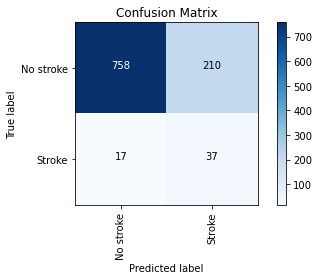

In [76]:
draw_confusion_matrix(y_test, nn_GS_preds, ["No stroke", "Stroke"])

## Custom models

### KNN Classifier

In [65]:
n_neighbors_arr = np.linspace(5, 100, 20, endpoint=True).astype(int)

knn_params = dict(n_neighbors=n_neighbors_arr)
knn_params = {'kneighborsclassifier__' + key: knn_params[key] for key in knn_params}

In [185]:
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
up_knn_pipeline = make_pipeline(SMOTE(random_state=0), KNeighborsClassifier())
knn_GS = GridSearchCV(up_knn_pipeline, param_grid=knn_params, cv=kf, scoring='f1', return_train_score=True)
knn_GS.fit(X_train, y_train)

best_n_neighbors = knn_GS.best_estimator_.get_params()['kneighborsclassifier__n_neighbors']
best_score = knn_GS.best_score_

print('Best n_neighbors:', best_n_neighbors)
print('Best score:', best_score)

Best n_neighbors: 30
Best score: 0.21024315377857378


In [186]:
knn_GS_preds = knn_GS.predict(X_test)
print_metrics(y_test, knn_GS_preds)

Accuracy:    0.741683
Precision:   0.125000
Recall:      0.648148
F1 score:    0.209581


In [67]:
knn_GS_preds = knn_GS.predict(X_test)
print_metrics(y_test, knn_GS_preds)

Accuracy:    0.734834
Precision:   0.121951
Recall:      0.648148
F1 score:    0.205279


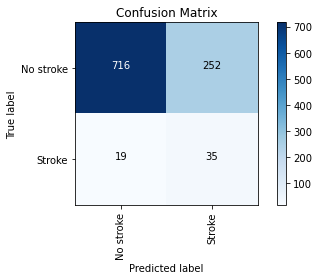

In [77]:
draw_confusion_matrix(y_test, knn_GS_preds, ["No stroke", "Stroke"])

### SVM

In [68]:
kernel_arr = ['linear', 'poly', 'rbf', 'sigmoid']

svm_params = dict(kernel=kernel_arr)
svm_params = {'svc__' + key: svm_params[key] for key in svm_params}

In [69]:
# use a pipeline with GridSearchCV to upsample inside cross-validating decision trees to find best parameters
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
up_svm_pipeline = make_pipeline(SMOTE(random_state=0), SVC(random_state=0))
svm_GS = GridSearchCV(up_svm_pipeline, param_grid=svm_params, cv=kf, scoring='f1', return_train_score=True)
svm_GS.fit(X_train, y_train)

best_kernel = svm_GS.best_estimator_.get_params()['svc__kernel']
best_score = svm_GS.best_score_

print('Best kernel:', best_kernel)
print('Best score:', best_score)

Best kernel: linear
Best score: 0.23129667922918745


In [70]:
svm_GS_preds = svm_GS.predict(X_test)
print_metrics(y_test, svm_GS_preds)

Accuracy:    0.767123
Precision:   0.146154
Recall:      0.703704
F1 score:    0.242038


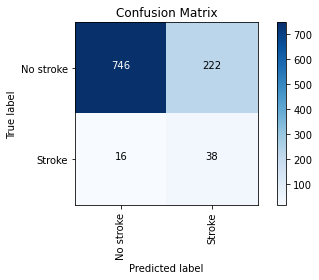

In [78]:
draw_confusion_matrix(y_test, svm_GS_preds, ["No stroke", "Stroke"])